Inspiration taken from https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/ as well as https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# np.any(np.isfinite()) to check for nans and infs

path = "/content/drive/My Drive/Lightcurves_CSVUniformBin/"
metadata_path = "/content/drive/My Drive/finaldata.csv"

all_points = []

fields = []
rows = []
with open(metadata_path, 'r') as file:
    read = csv.reader(file)
    fields = next(read)
    for row in read:
        rows.append(row)
index_location = fields.index("Depth (ppm)")

for c in range(0, 4000):
  points = []

  depth = rows[c][index_location]

  if(float(depth) >= 1000.0):

    try:

      with open(path + "fig" + str(c) + ".csv", 'r') as file:

          read = csv.reader(file)
          read = list(read)
          x_data = read[0]
          y_data = read[1]
          for a in range(len(x_data)):
            x_data[a] = float(x_data[a])
            y_data[a] = float(y_data[a])

          if(len(x_data) == 301):
            
            x_data = np.divide(x_data, np.amax(x_data))
            y_data = np.array(y_data)

            for i in range(len(x_data)):
              points.append([x_data[i], y_data[i]])
            
            #imputing in for the nans
            imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
            imp.fit(points)
            points = imp.transform(points)

            new_x_data = []
            new_y_data = []
            for item in points:
              new_x_data.append(item[0])
              new_y_data.append(item[1])

            y_data = np.array(new_y_data)

            array_sum = np.sum(y_data)
            array_has_nan = np.isnan(array_sum)

            if(array_has_nan == True):
              print(str(c), array_has_nan)
            else:
              all_points.append(y_data)

          else:
            print("Fig " + str(c) + " was not the required length; has length " + str(len(x_data)))

    except:
      print("An error occurred with fig", str(c))
    
  else:
    print("fig", str(c), "depth is too small; has depth", depth)

fig 18 depth is too small; has depth 490
fig 19 depth is too small; has depth 420
fig 25 depth is too small; has depth 992.387849564357
fig 26 depth is too small; has depth 966.485069273326
fig 27 depth is too small; has depth 992.189433832835
fig 30 depth is too small; has depth 340
fig 32 depth is too small; has depth 397.283538251464
fig 36 depth is too small; has depth 619.124015084521
fig 43 depth is too small; has depth 196.012796708041
fig 46 depth is too small; has depth 306.252435964796
fig 48 depth is too small; has depth 480
fig 77 depth is too small; has depth 738.896229863582
fig 78 depth is too small; has depth 601.508566229395
fig 79 depth is too small; has depth 289.997034623129
fig 80 depth is too small; has depth 135.566248187729
fig 81 depth is too small; has depth 157.495771308736
fig 84 depth is too small; has depth 673.834306389534
fig 90 depth is too small; has depth 532.75806233683
fig 99 depth is too small; has depth 205.234862115585
fig 101 depth is too small;

In [ ]:
sequence = np.array(all_points)
num_samples = len(sequence)
timesteps = len(sequence[0])

print(num_samples)
print(timesteps)
print(sequence.shape)

sequence = sequence.reshape(num_samples, timesteps)
print(sequence)
print(sequence.shape)

3026
301
(3026, 301)
[[ 0.92867328  0.97217974  0.93398217 ...  0.92474405  0.91618058
  -1.        ]
 [ 0.9816004   0.97841091  0.97501565 ...  0.97877959  0.97334374
   0.97452693]
 [ 0.86324818  0.84545057  0.87659408 ...  0.85977144  0.90338706
   0.81964635]
 ...
 [ 0.9145605   0.91337262  0.94152525 ...  0.921521    0.93748671
   0.93415861]
 [ 0.24231919  0.3751709   0.73351109 ...  0.44466334  0.48064724
   0.55525174]
 [ 0.81860272  0.36603497  0.49493947 ... -1.          0.38238252
  -1.        ]]
(3026, 301)


In [ ]:
original_dim = 301
intermediate_dim = 32
latent_dim = 5

inputs = keras.Input(shape=(original_dim,))
input_reshaped = layers.Reshape((original_dim, 1))(inputs)
masked = layers.Masking(mask_value=-1.0)(input_reshaped)
y = layers.Conv1D(intermediate_dim, 3, activation='relu', input_shape=(original_dim, 1))(masked)
flat = layers.Flatten()(y)
h = layers.Dense(intermediate_dim, activation='relu')(flat) 

z_mean = layers.Dense(latent_dim)(h) 
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
from keras import backend as K

def sampling(args): #creating a sampling function
    z_mean, z_log_sigma = args 
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1) #generating a random distribution given the parameters
    return z_mean + K.exp(z_log_sigma) * epsilon #mean + element-wise exponential

z = layers.Lambda(sampling)([z_mean, z_log_sigma]) #Lambda wraps arbitrary expressions as a layer
#uses the sampling function we just created and the arguments of z_mean and z_log_sigma from the layers before

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model maps inputs to the three outputs here

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling') #passes in the z-sampling distribution from before
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs) 
mid = layers.Dense(9568, activation='relu')(x) 
y = layers.Reshape((299, intermediate_dim))(mid)
outputs = layers.Conv1DTranspose(1, 3, activation='relu', input_shape=(intermediate_dim, 1))(y)
outputs = layers.Reshape((301,))(outputs)

#OLD CODE
'''outputs = layers.Dense(original_dim, activation='sigmoid')(x)
outputs = layers.Reshape((301, 1))(outputs)'''

decoder = keras.Model(latent_inputs, outputs, name='decoder') #maps the z-sampling to outputs of the original size of 301

# instantiate VAE model
outputs = decoder(encoder(inputs)[2]) #output is encoding the input and then decoding it again
vae = keras.Model(inputs, outputs, name='vae_mlp') #maps the original inputs to the encoded-then-decoded inputs

encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 301)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 301, 1)       0           ['input_1[0][0]']                
                                                                                                  
 masking (Masking)              (None, 301, 1)       0           ['reshape[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 299, 32)      128         ['masking[0][0]']                
                                                                                            

In [ ]:
#creating a custom loss function
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma) #kl_loss is regularizing the latent space
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

In [ ]:
history = vae.fit(sequence, sequence, epochs=300, batch_size=100, validation_split=0.2)

Epoch 1/300
25/25 [==============================] - 4s 64ms/step - loss: 243.6146 - val_loss: -592.4927
Epoch 2/300
25/25 [==============================] - 1s 52ms/step - loss: -154.1558 - val_loss: -702.1320
Epoch 3/300
25/25 [==============================] - 1s 50ms/step - loss: -223.1747 - val_loss: -681.6873
Epoch 4/300
25/25 [==============================] - 1s 49ms/step - loss: -218.3013 - val_loss: -699.2542
Epoch 5/300
25/25 [==============================] - 1s 49ms/step - loss: -226.3338 - val_loss: -756.4523
Epoch 6/300
25/25 [==============================] - 1s 50ms/step - loss: -329.0795 - val_loss: -818.5010
Epoch 7/300
25/25 [==============================] - 1s 50ms/step - loss: -396.1046 - val_loss: -845.7122
Epoch 8/300
25/25 [==============================] - 1s 51ms/step - loss: -435.2970 - val_loss: -864.2408
Epoch 9/300
25/25 [==============================] - 1s 51ms/step - loss: -452.5305 - val_loss: -876.5663
Epoch 10/300
25/25 [===========================

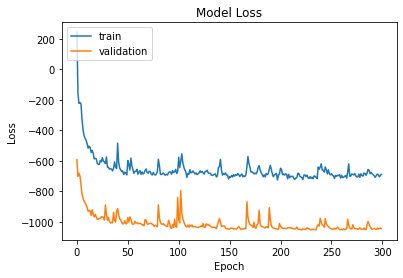

In [ ]:
#plotting loss vs. number of epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#creating a test sequence

path = "/content/drive/My Drive/Lightcurves_CSVUniformBin/"

all_predicted_points = []

for c in range(0, 4000):
  points = []

  try:

    with open(path + "fig" + str(c) + ".csv", 'r') as file:

        read = csv.reader(file)
        read = list(read)
        x_data = read[0]
        y_data = read[1]
        for a in range(len(x_data)):
          x_data[a] = float(x_data[a])
          y_data[a] = float(y_data[a])

        if(len(x_data) == 301):
          
          x_data = np.divide(x_data, np.amax(x_data))
          y_data = np.array(y_data)

          for i in range(len(x_data)):
            points.append([x_data[i], y_data[i]])
          
          #imputing in for the nans
          imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)
          imp.fit(points)
          points = imp.transform(points)

          new_x_data = []
          new_y_data = []
          for item in points:
            new_x_data.append(item[0])
            new_y_data.append(item[1])

          y_data = np.array([c] + new_y_data)

          array_sum = np.sum(y_data)
          array_has_nan = np.isnan(array_sum)

          if(array_has_nan == True):
            print(str(c), array_has_nan)
          else:
            np.insert(y_data, 0, c)
            # print(c)
            all_predicted_points.append(y_data)

        else:
          print("Fig " + str(c) + " was not the required length; has length " + str(len(x_data)))

  except:
    print("An error occurred with fig", str(c))

c_values = []

for i in range(len(all_predicted_points)):
  all_predicted_points[i] = all_predicted_points[i].tolist()
  c_values.append(all_predicted_points[i].pop(0))
  all_predicted_points[i] = np.array(all_predicted_points[i])

predicted_sequence = np.array(all_predicted_points)

num_samples = len(predicted_sequence)
timesteps = len(predicted_sequence[0])

print(num_samples)
print(timesteps)
print(predicted_sequence.shape)

predicted_sequence = predicted_sequence.reshape(num_samples, timesteps)
print(predicted_sequence.shape)

prediction = encoder.predict(predicted_sequence)

latent_size = len(prediction)
dimension = len(prediction[0])
z = len(prediction[2][0])

prediction0 = np.array(prediction[0])
prediction0 = prediction0.reshape(dimension, z)

prediction1 = np.array(prediction[1])
prediction1 = prediction1.reshape(dimension, z)

prediction2 = np.array(prediction[2])
prediction2 = prediction2.reshape(dimension, z)

# print(prediction0)
# print(prediction1)
# print(prediction2)

An error occurred with fig 139
An error occurred with fig 142
An error occurred with fig 143
An error occurred with fig 144
An error occurred with fig 215
An error occurred with fig 252
An error occurred with fig 361
An error occurred with fig 458
An error occurred with fig 460
An error occurred with fig 477
An error occurred with fig 580
An error occurred with fig 639
An error occurred with fig 690
An error occurred with fig 874
An error occurred with fig 914
An error occurred with fig 1026
An error occurred with fig 1051
An error occurred with fig 1054
An error occurred with fig 1083
An error occurred with fig 1114
An error occurred with fig 1175
An error occurred with fig 1185
An error occurred with fig 1255
An error occurred with fig 1272
An error occurred with fig 1357
An error occurred with fig 1379
An error occurred with fig 1386
An error occurred with fig 1493
An error occurred with fig 1495
An error occurred with fig 1570
An error occurred with fig 1572
An error occurred with 

In [ ]:
#Saving the latent space to another .csv file
for i in range(len(prediction0)):
  prediction0[i] = prediction0[i].tolist()
prediction0 = prediction0.tolist()

for i in range(len(prediction0)):
  prediction0[i].append(c_values[i])
prediction0 = np.array(prediction0)

pd.DataFrame(prediction0).to_csv("/content/drive/My Drive/latentspacefinal.csv")

Predicted:


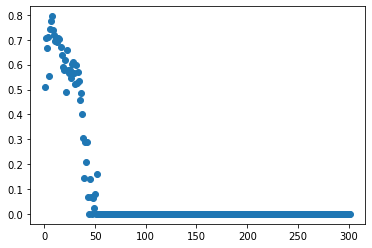

Actual:


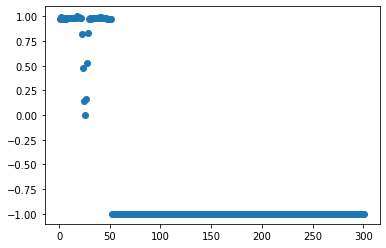

Predicted:


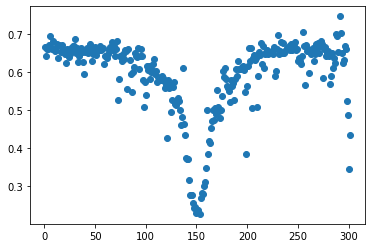

Actual:


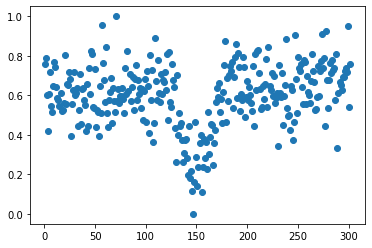

Predicted:


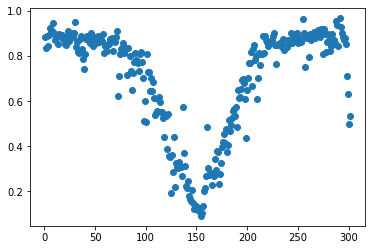

Actual:


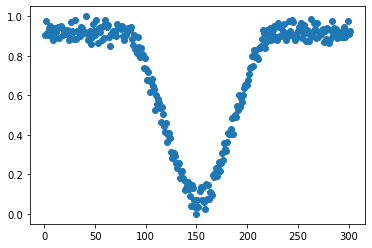

Predicted:


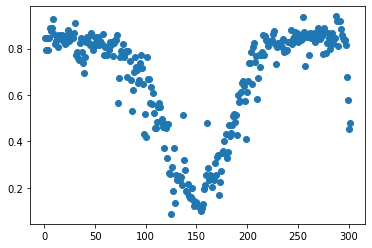

Actual:


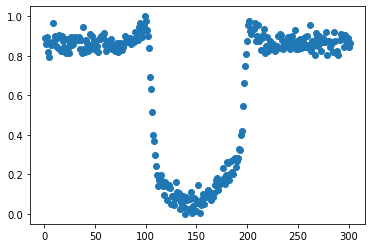

Predicted:


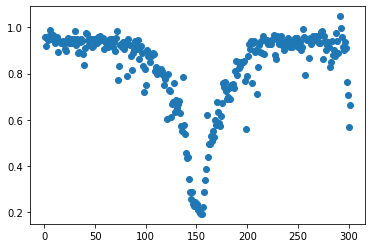

Actual:


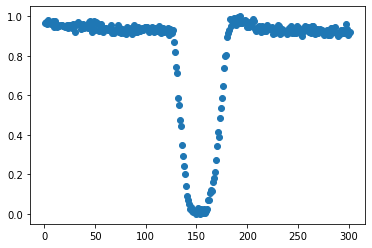

Predicted:


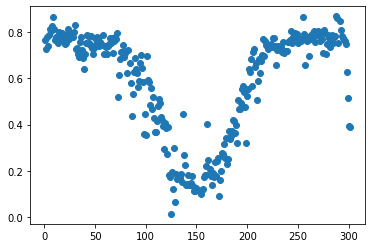

Actual:


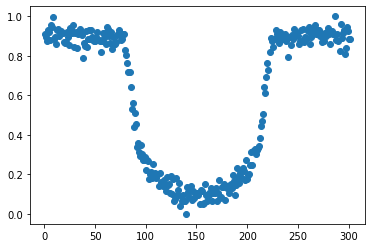

Predicted:


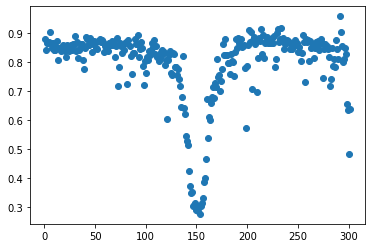

Actual:


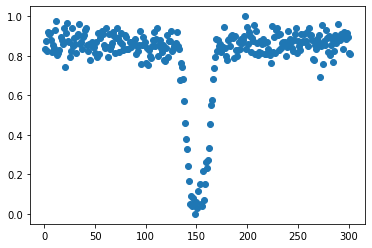

Predicted:


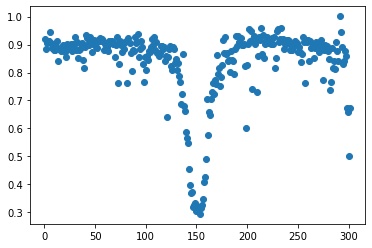

Actual:


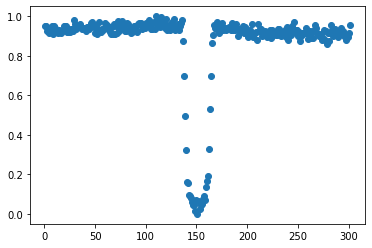

Predicted:


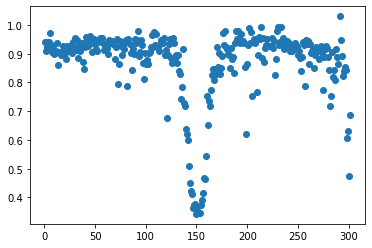

Actual:


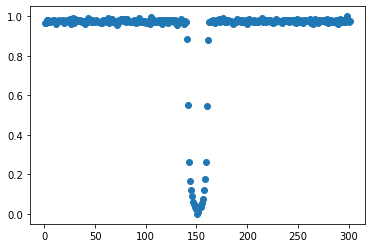

Predicted:


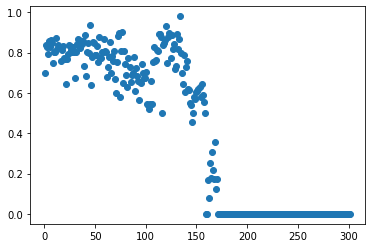

Actual:


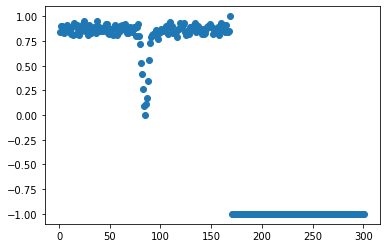

Predicted:


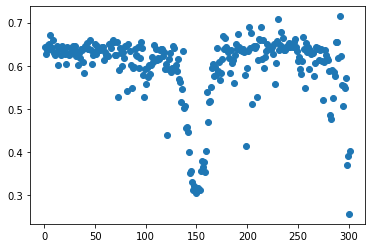

Actual:


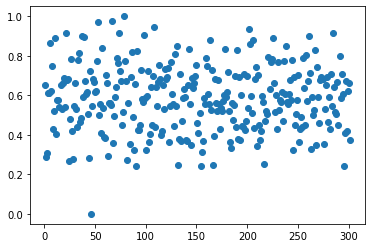

Predicted:


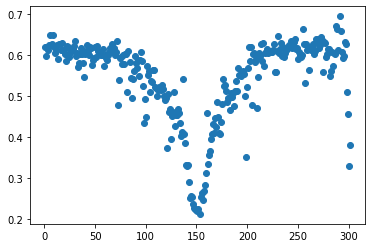

Actual:


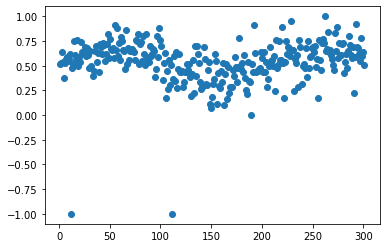

Predicted:


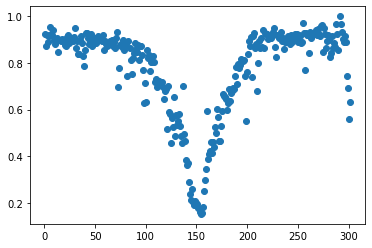

Actual:


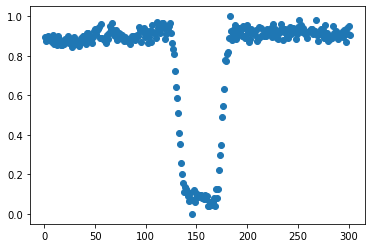

Predicted:


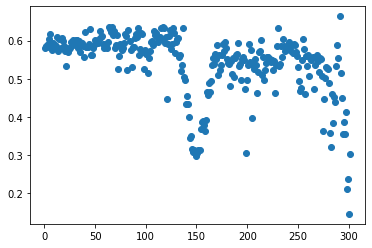

Actual:


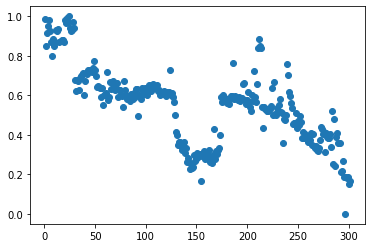

Predicted:


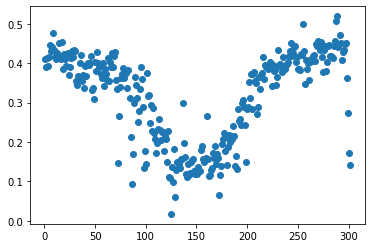

Actual:


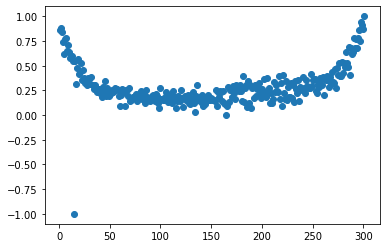

Predicted:


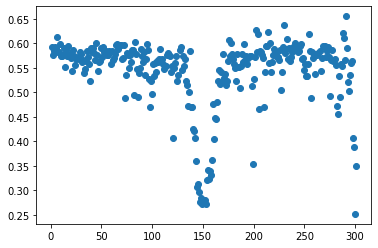

Actual:


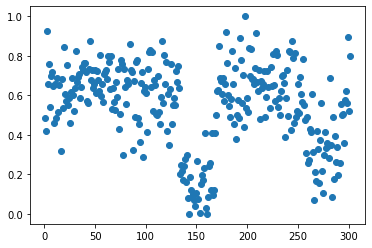

Predicted:


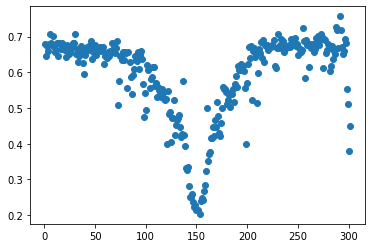

Actual:


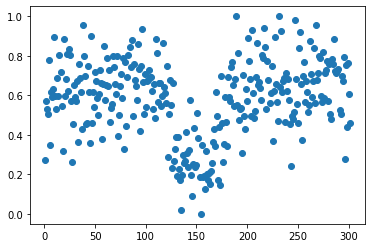

Predicted:


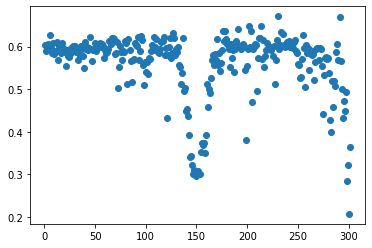

Actual:


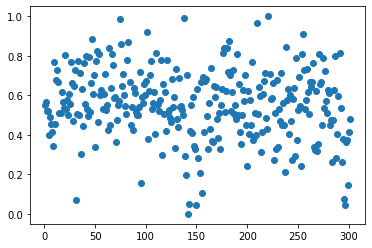

Predicted:


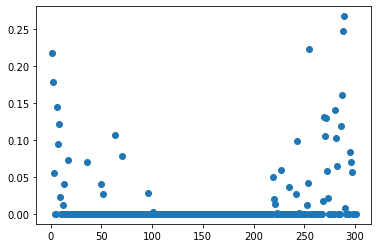

Actual:


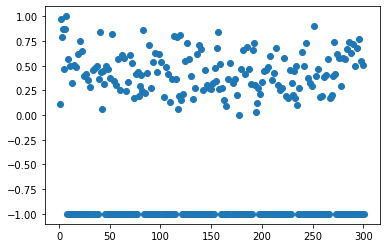

Predicted:


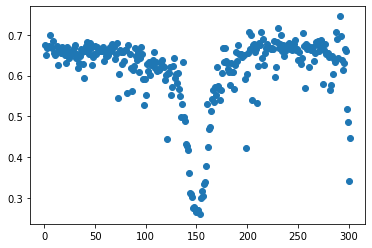

Actual:


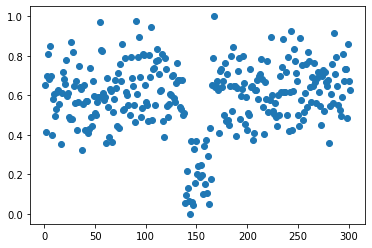

In [ ]:
prediction = vae.predict(predicted_sequence, verbose=0)

for j in range(len(prediction)):

  print("Predicted:")
  x_data = np.arange(start=1, stop=302)
  y_data = prediction[j]

  plot_points = []
  for i in range(len(x_data)):
      plot_points.append([x_data[i], y_data[i]])

  plot_points = np.array(plot_points)
  x, y = plot_points.T
  plt.scatter(x,y)
  plt.show()
  plt.close()

  print("Actual:")
  x_data = np.arange(start=1, stop=302)
  y_data = predicted_sequence[j]

  plot_points = []
  for i in range(len(x_data)):
      plot_points.append([x_data[i], y_data[i]])

  plot_points = np.array(plot_points)
  x, y = plot_points.T
  plt.scatter(x,y)
  plt.show()
  plt.close()